In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def generate_dataset(X,Y,
        x0,y0,R,
        error=0.3,drop_rate=0.1
        ):
    df=pd.DataFrame({'x':X,'y':Y})
    df_in_circle=df[(df['x']-x0)**2+(df['y']-y0)**2<R**2]
    df_in_circle.loc[:, 'x'] += np.random.uniform(-error, error, len(df_in_circle))
    df_in_circle.loc[:, 'y'] += np.random.uniform(-error, error, len(df_in_circle))
    df_in_circle=df_in_circle.sample(frac=1-drop_rate)
    return df_in_circle

def transform_dataset(x0,y0,theta,df_in_circle):
    # 平移df_in_circle到原点
    df_in_circle.loc[:, 'x'] -= x0
    df_in_circle.loc[:, 'y'] -= y0
    # 绕圆心旋转df_in_circle中的点theta角
    x_new=df_in_circle['x']*np.cos(theta)-df_in_circle['y']*np.sin(theta)
    y_new=df_in_circle['x']*np.sin(theta)+df_in_circle['y']*np.cos(theta)
    df_in_circle['x']=x_new
    df_in_circle['y']=y_new
    return df_in_circle


In [9]:
filename='axicon_pattern_crossflower.csv'
df = pd.read_csv(filename)
X=df['x']
Y=df['y']

x0,y0=np.random.uniform(-20,20,2)
measure_diameter=17
theta=np.random.uniform(0,2*np.pi)
theta=0

df_in_circle=generate_dataset(X,Y,x0,y0,measure_diameter/2,error=0.1)
df_in_circle=transform_dataset(x0,y0,theta,df_in_circle)
df_in_circle.to_csv('axicon_pattern_crossflower_measure.csv',index=False)

data_measured=df_in_circle
data_original=df

In [10]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def estimate_rigid_transform(A, B):
    """
    使用最小二乘法估计刚体变换，包括旋转和平移。
    A 和 B 是对应点的集合，形状为 (n_points, 2)。
    返回旋转矩阵 R 和平移向量 t。
    """
    assert len(A) == len(B)

    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    A_centered = A - centroid_A
    B_centered = B - centroid_B

    H = A_centered.T @ B_centered
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    t = centroid_B - R @ centroid_A

    return R, t

def ransac_translation_rotation_focused_sampling(data, model, n_iter, threshold, radius):
    best_transform = None
    max_inliers = 0

    data_coords = data[['x', 'y']].values
    model_coords = model[['x', 'y']].values

    for _ in range(n_iter):
        center_idx = np.random.choice(len(model_coords))
        center_point = model_coords[center_idx]
        distances = np.linalg.norm(model_coords - center_point, axis=1)
        close_points_idx = np.where(distances < radius)[0]
        selected_model_points = model_coords[close_points_idx]

        nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(data_coords)
        distances, indices = nbrs.kneighbors(selected_model_points)

        model_matched = selected_model_points
        data_matched = data_coords[indices.flatten()]

        # Estimate both rotation and translation
        R, t = estimate_rigid_transform(model_matched, data_matched)
        transformed_model = (model_coords @ R.T) + t

        # Count inliers
        nbrs.fit(transformed_model)
        distances, _ = nbrs.kneighbors(data_coords)
        inliers = np.sum(distances < threshold)

        # Update the best transformation
        if inliers > max_inliers:
            max_inliers = inliers
            best_transform = (R, t)

    return best_transform

# Updated RANSAC parameters for focused sampling with rotation
radius_sampling = 10  # Define an appropriate radius based on the dataset characteristics
n_iter_translation_rotation = 10
threshold_translation_rotation = 0.01

# Run RANSAC with focused sampling including rotation
best_transform_focused = ransac_translation_rotation_focused_sampling(
    data_measured, data_original, n_iter_translation_rotation, threshold_translation_rotation, radius_sampling)

print("Best Transformation (Rotation, Translation):", best_transform_focused)


118 118
65 65
63 63
119 119
109 109
109 109
81 81
116 116
109 109
111 111
Best Transformation (Rotation, Translation): None


In [11]:
print(x0,y0)
print(best_transform_focused[1])


-4.908890950617067 19.58215059163144


TypeError: 'NoneType' object is not subscriptable

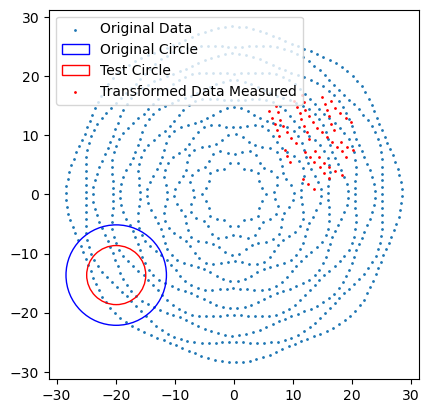

In [ ]:


# 假设 best_transform_focused 是形如 (R, t) 的元组
R, t = best_transform_focused

# 应用旋转和平移
data_measured_coords = data_measured[['x', 'y']].values
transformed_data_measured = (data_measured_coords @ R.T) + t

# 绘制图形
fig, ax = plt.subplots()
# 绘制原始数据点
ax.scatter(data_original['x'], data_original['y'], s=1, label='Original Data')
# 绘制圆形区域
circle_ori = plt.Circle((x0, y0), measure_diameter/2, fill=False, color='blue', label='Original Circle')
ax.add_artist(circle_ori)
circle_test = plt.Circle((x0, y0), 5, fill=False, color='red', label='Test Circle')
ax.add_artist(circle_test)

# 绘制变换后的数据点
ax.scatter(transformed_data_measured[:, 0], transformed_data_measured[:, 1], s=1, color='red', label='Transformed Data Measured')
ax.set_aspect('equal')

# 设置图例
ax.legend()

# 显示图形
plt.show()
